# JPEG Experiment Visualization

## Setting up the Data

In [5]:
# Setup the dataset
# You might have to adjust the data_path in settings.py and setup.py files
!python src/data/setup.py

## Import Modules

In [13]:
# External Imports
import os
import re
from io import BytesIO
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import copy


# GitLab Code imports
sys.path.insert(0, './src/models/')
import src.training.train_and_test as tnt
from src.data.preprocess import mean, std
from settings import img_size, test_batch_size
from src.data.customdataset import CustomImageFolder
from src.utils.local_analysis import LocalAnalysis

# Random Seed
random_seed = 42
torch.manual_seed(random_seed)

## Prepare Data

In [7]:
# Directories
# You might have to change this directory path
directory = "/home/username/Downloads/CUB_200_2011/datasets/cub200_cropped"
directory_test = directory + "test_cropped/"

In [8]:
def JPEGcompression(image):
    """Applies JPEG compression of quality JPEG_QUALITY
    Args:
        image (PIL Image): uncompressed image
    Returns:
        Compressed Image
    """
    outputIoStream = BytesIO()
    image.save(outputIoStream, "JPEG", quality=JPEG_QUALITY, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

In [9]:
normalize = transforms.Normalize(mean=mean, std=std)


# Test data, where 50% of the images are uncompressed and the other 
# 50% of the images are compressed. It is processed in the CustomImageFolder class
test_dataset = CustomImageFolder(
    directory_test,
    transform= transforms.Compose([   
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]),
    target_specific_transform= transforms.Compose([
        transforms.Lambda(JPEGcompression) # Apply JPEG compression as transform
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)


# Test data, where are the images are uncompressed
test_dataset_all_clean = datasets.ImageFolder(
    directory_test,
    transforms.Compose([ 
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))

test_loader_all_clean = torch.utils.data.DataLoader(
    test_dataset_all_clean, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)



## Load Network

Model Paths:

- ResNet18 - /content/jpeg_saved_models/resnet18/002/10_19push0.8019.pth
- ResNet34 - /content/jpeg_saved_models/resnet34/002/10_18push0.8214.pth
- VGG19 - /content/jpeg_saved_models/vgg19/002/10_19push0.8108.pth

In [10]:
# Select Network, and specify Experiment run
base_architecture = 'vgg19' #'resnet34', 'vgg19'
experiment_run = '002'

# Model directory
load_model_dir = '/home/username/Downloads/jpeg_saved_models/{}/002/'.format(base_architecture)
load_model_name = '10_19push0.8108.pth'

# Specify the folder to save the images and logs
save_dir = '/home/username/Downloads/' + base_architecture + '/' + experiment_run + '/'
! mkdir -p {save_dir}

In [11]:
loc_analysis = LocalAnalysis(load_model_dir, load_model_name, "", image_save_directory = save_dir)

load model from /content/jpeg_saved_models/vgg19/002/10_19push0.8108.pth
model base architecture: vgg19
experiment run: 002
Prototypes are chosen from 200 number of classes.
Their class identities are: [  0   0   0 ... 199 199 199]
All prototypes connect most strongly to their respective classes.


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

## Check Model Performance

In [12]:
JPEG_QUALITY = 20

protopnet = loc_analysis.ppnet_multi

print("Accuracy on test data set with half the classes being jpeg compressed and the other half uncompressed")
tnt.test(model=protopnet, dataloader=test_loader, 
         class_specific=loc_analysis.class_specific, 
         log=loc_analysis.log)
print("")

print("Accuracy on test data set with no jpeg compressed classes")
tnt.test(model=protopnet, dataloader=test_loader_all_clean, 
         class_specific=loc_analysis.class_specific, 
         log=loc_analysis.log)
print("")

Accuracy on test data set with half the classes being jpeg compressed and the other half uncompressed
	test
	time: 	34.68465614318848
	cross ent: 	0.879778436545668
	cluster: 	0.04814469522057936
	separation:	0.04963448688644787
	avg separation:	1.5077869439947194
	accu: 		81.08387987573352%
	l1: 		2381.32861328125
	p dist pair: 	3.394124746322632

Accuracy on test data set with no jpeg compressed classes
	test
	time: 	60.90116739273071
	cross ent: 	3.475628918614881
	cluster: 	0.10317516333327212
	separation:	0.047090255366317155
	avg separation:	1.5334929967748707
	accu: 		49.603037625129446%
	l1: 		2381.32861328125
	p dist pair: 	3.394124746322632



## Visualize and inspect the prototypes

## Visualize Prototypes

Predicted: 1	 Actual: 1	 Prediction is correct.
image index 0 in batch
protoype index: 16
prototype class identity: 1
activation value (similarity score): 4.2432146072387695
------------------------------
Predicted: 44	 Actual: 1	 Prediction is wrong.
image index 0 in batch
protoype index: 16
prototype class identity: 1
prototype connection identity: 1
activation value (similarity score): 1.937483310699463
------------------------------


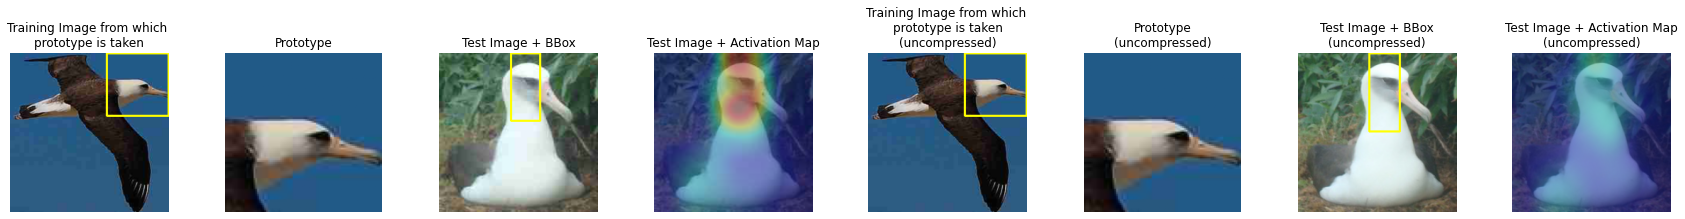



Predicted: 21	 Actual: 21	 Prediction is correct.
image index 0 in batch
protoype index: 216
prototype class identity: 21
activation value (similarity score): 4.71732759475708
------------------------------
Predicted: 21	 Actual: 21	 Prediction is correct.
image index 0 in batch
protoype index: 216
prototype class identity: 21
activation value (similarity score): 3.9793879985809326
------------------------------


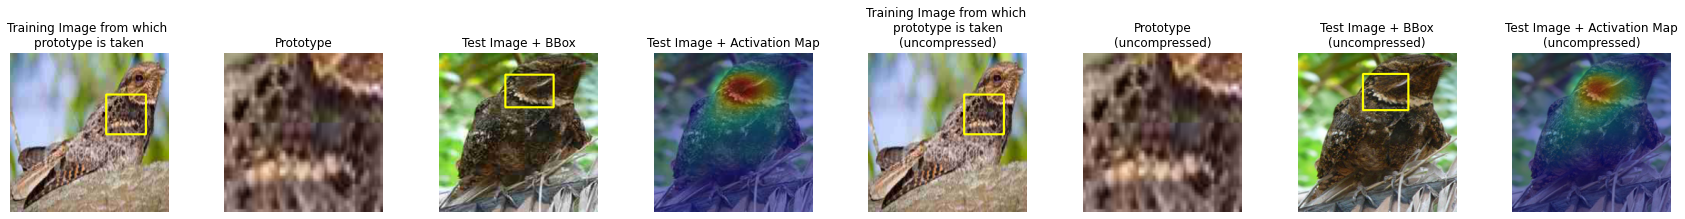



Predicted: 41	 Actual: 41	 Prediction is correct.
image index 0 in batch
protoype index: 419
prototype class identity: 41
activation value (similarity score): 4.601229667663574
------------------------------
Predicted: 138	 Actual: 41	 Prediction is wrong.
image index 0 in batch
protoype index: 419
prototype class identity: 41
prototype connection identity: 41
activation value (similarity score): 2.2643418312072754
------------------------------


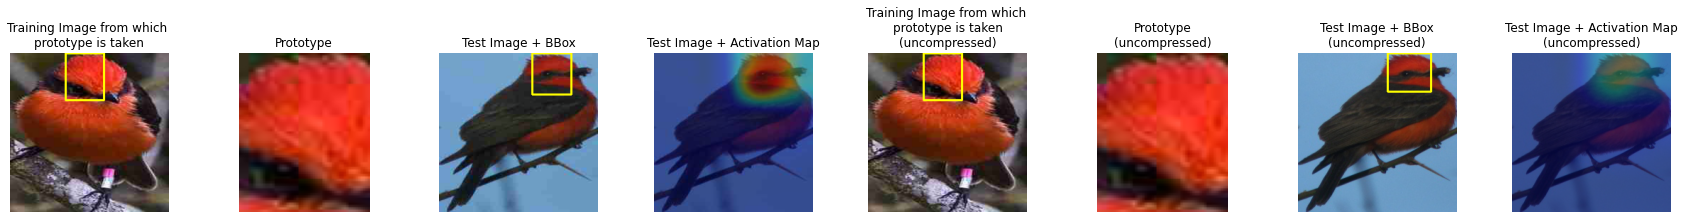



Predicted: 65	 Actual: 61	 Prediction is wrong.
image index 0 in batch
protoype index: 719
prototype class identity: 71
activation value (similarity score): 3.1407055854797363
------------------------------
Predicted: 64	 Actual: 61	 Prediction is wrong.
image index 0 in batch
protoype index: 719
prototype class identity: 71
prototype connection identity: 71
activation value (similarity score): 1.519855260848999
------------------------------


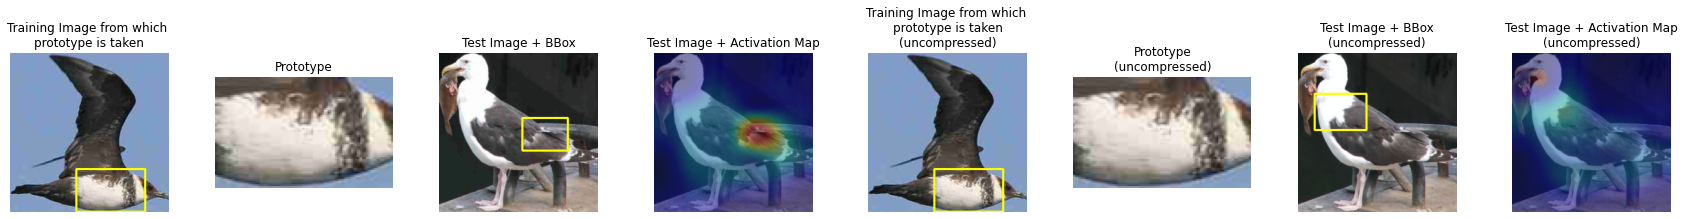



Predicted: 81	 Actual: 81	 Prediction is correct.
image index 0 in batch
protoype index: 811
prototype class identity: 81
activation value (similarity score): 7.223883152008057
------------------------------
Predicted: 78	 Actual: 81	 Prediction is wrong.
image index 0 in batch
protoype index: 811
prototype class identity: 81
prototype connection identity: 81
activation value (similarity score): 2.870471954345703
------------------------------


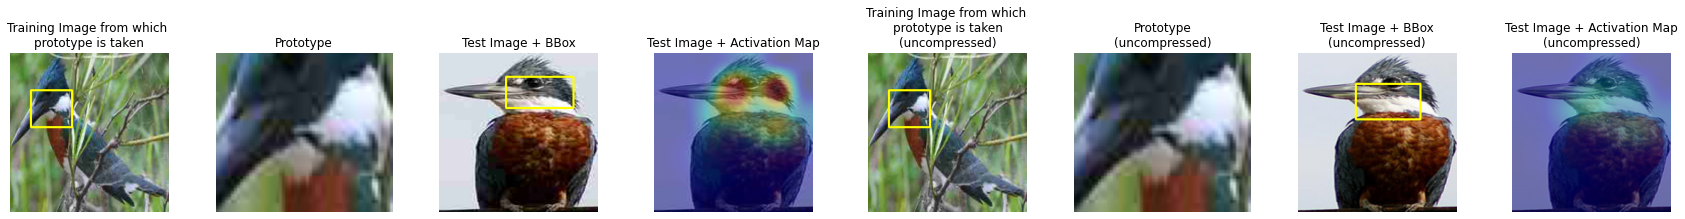



Predicted: 101	 Actual: 101	 Prediction is correct.
image index 0 in batch
protoype index: 392
prototype class identity: 39
activation value (similarity score): 3.6165249347686768
------------------------------
Predicted: 102	 Actual: 101	 Prediction is wrong.
image index 0 in batch
protoype index: 392
prototype class identity: 39
prototype connection identity: 39
activation value (similarity score): 1.454200029373169
------------------------------


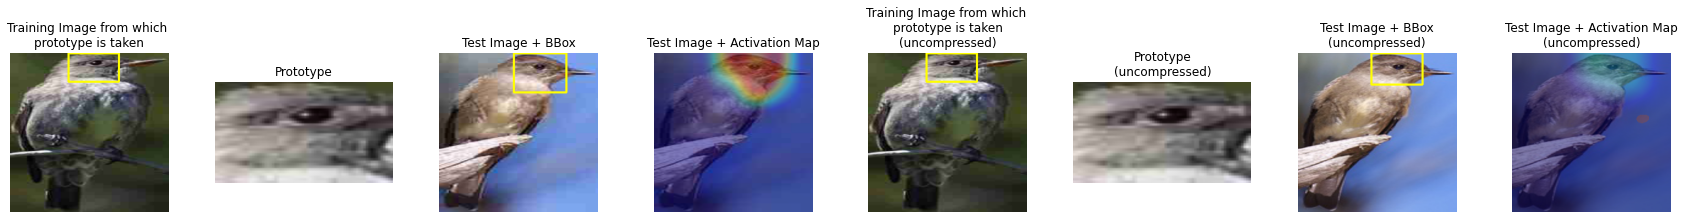



Predicted: 121	 Actual: 121	 Prediction is correct.
image index 0 in batch
protoype index: 1211
prototype class identity: 121
activation value (similarity score): 5.463100433349609
------------------------------
Predicted: 121	 Actual: 121	 Prediction is correct.
image index 0 in batch
protoype index: 1211
prototype class identity: 121
prototype connection identity: 121
activation value (similarity score): 2.111501693725586
------------------------------


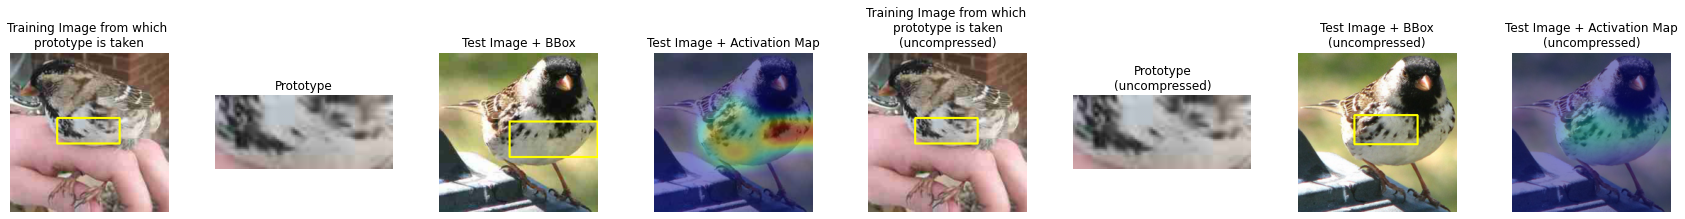



Predicted: 141	 Actual: 141	 Prediction is correct.
image index 0 in batch
protoype index: 1451
prototype class identity: 145
activation value (similarity score): 3.5181784629821777
------------------------------
Predicted: 144	 Actual: 141	 Prediction is wrong.
image index 0 in batch
protoype index: 1451
prototype class identity: 145
prototype connection identity: 145
activation value (similarity score): 0.40561801195144653
------------------------------


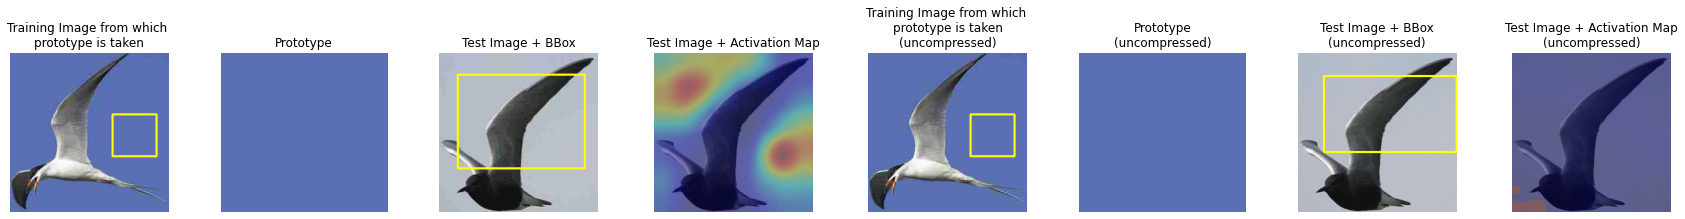



Predicted: 161	 Actual: 161	 Prediction is correct.
image index 0 in batch
protoype index: 1615
prototype class identity: 161
activation value (similarity score): 5.468467712402344
------------------------------
Predicted: 161	 Actual: 161	 Prediction is correct.
image index 0 in batch
protoype index: 1615
prototype class identity: 161
activation value (similarity score): 2.233448028564453
------------------------------


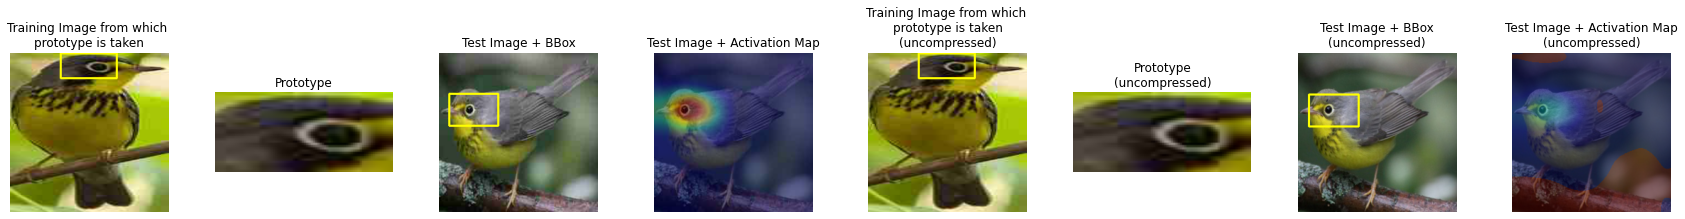



Predicted: 181	 Actual: 181	 Prediction is correct.
image index 0 in batch
protoype index: 1810
prototype class identity: 181
activation value (similarity score): 3.875910758972168
------------------------------
Predicted: 181	 Actual: 181	 Prediction is correct.
image index 0 in batch
protoype index: 1810
prototype class identity: 181
prototype connection identity: 181
activation value (similarity score): 1.6212772130966187
------------------------------


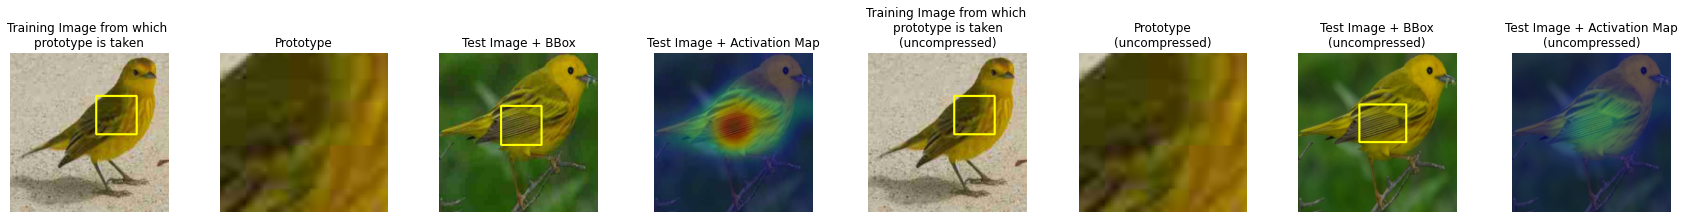

In [13]:
JPEG_QUALITY = 20

# Retrieve test data classes
classes = sorted(os.listdir(directory_test))

sample_images = 10

# Loop over every fourth class, which has also been compressed during training
for i in range(sample_images):

    # Calculate the test image label
    test_image_label = (len(classes)//sample_images)*i+1

    # Choose an odd class: that's why we add +1 in the index
    # If we don't add 1, then we only inspect even classes, and we can see the inverse effect
    test_image_dir = directory_test+classes[(len(classes)//sample_images)*i+1]
    image_list = os.listdir(test_image_dir)
    
    # Index for test images
    j = 1
    test_image_path = os.path.join(test_image_dir, image_list[j])

    # Compression Processing Pipeline
    preprocess_corrupted = transforms.Compose([
                transforms.Lambda(JPEGcompression),
                transforms.Resize(size=(img_size, img_size)),
                transforms.ToTensor(),
                normalize,
            ])
    
    # Normal Processing Pipeline
    preprocess_clean = transforms.Compose([
                transforms.Resize(size=(img_size, img_size)),
                transforms.ToTensor(),
                normalize,
            ])

    img_pil = Image.open(test_image_path)

    # Show the results
    loc_analysis.jpeg_visualization(img_pil, image_list[j].split(".")[0], 
                                    test_image_label,
                                    preprocess_clean, preprocess_corrupted, 
                                    show_images=True)
    print("")
    print("")